In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import *

from models import *
from utils import *
from data import *

In [25]:
ts = Temperatures(path=None, normalize=True)
data = ts.data

X_train, y_train, X_val, y_val, X_test, y_test = windowing(data, 30)
X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t = map(
    asTorch,
    (X_train, y_train, X_val, y_val, X_test, y_test)
)


In [26]:
forecasters = {
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(),
}

for name, model in forecasters.items():
    print(f"→ Training {name}…")
    model.fit(X_train, y_train)

→ Training LinearRegression…
→ Training RandomForest…


In [ ]:
for model in forecasters.values():
    model.roc.clear()

for idx, window in enumerate(X_val):
    errors = {}
    for name, model in forecasters.items():
        y_pred = model.predict(window)
        errors[name] = (y_val[idx] - y_pred)**2

    winner = min(errors, key=errors.get)
    forecasters[winner].roc.append(idx)
    print(f"Window {idx:3d} → best model = {winner}  (error = {errors[winner]:.4f})")

print("\nRoC sizes:")
for name, model in forecasters.items():
    print(f"  {name:<18} {len(model.roc)} windows")

InvalidParameterError: The 'y_true' parameter of mean_squared_error must be an array-like. Got 1.0125187930104667 instead.

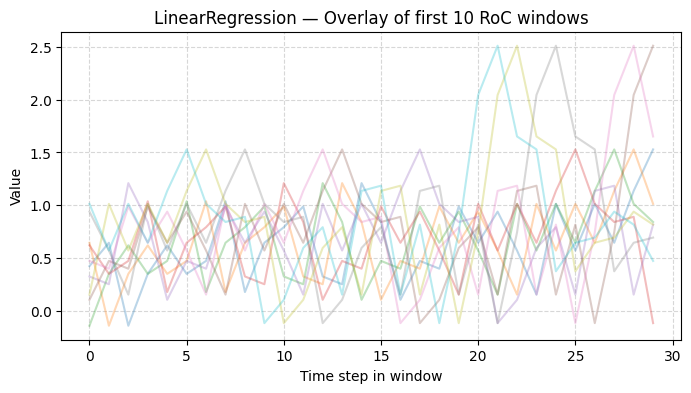

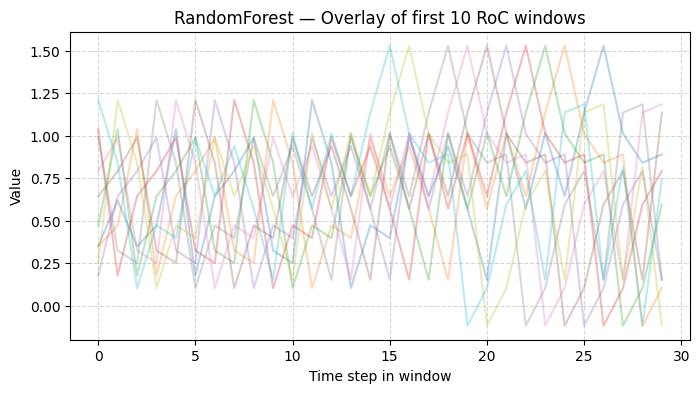

In [22]:
num_to_plot = 10  # how many windows to overlay per model

for name, model in forecasters.items():
    wins = model.roc[:num_to_plot]
    if not wins:
        print(f"{name}: no RoC windows to plot.")
        continue

    plt.figure(figsize=(8, 4))
    for idx in wins:
        w = X_val[idx]
        plt.plot(w, alpha=0.3)            # overlay each window with some transparency

    plt.title(f"{name} — Overlay of first {len(wins)} RoC windows")
    plt.xlabel("Time step in window")
    plt.ylabel("Value")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()